In [24]:
import numpy as np
from commpy import PSKModem, QAMModem
from matplotlib import pyplot as plt
from matplotlib import pyplot


import numpy as np
from commpy import PSKModem, QAMModem
from matplotlib import pyplot as plt
from matplotlib import pyplot  
from scipy.signal import find_peaks
import pandas as pd
import scipy.stats as st
from scipy import signal

from sklearn import mixture


In [2]:
#
# Set up the constellation and some constants for QPSK
##
nsymbols=4
repeats_per_symbol = 16
samples_per_second = 1000
message_len = 3000
total_samples = repeats_per_symbol*message_len
baseband_carrier_freq = 3000
noise_sd = 0.01

duration = total_samples/samples_per_second
time = np.linspace(0,duration, total_samples)/samples_per_second  # clock time of each sample

[0.048]


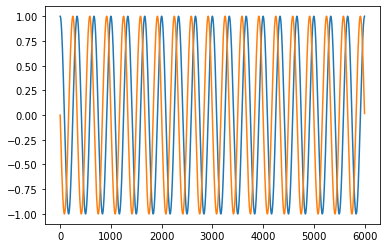

In [3]:

#
# Setup the baseband
#
print(time[-1:])
baseband_signal =  np.cos(2*np.pi*time*baseband_carrier_freq)   - 1j *np.sin(2*np.pi*time*baseband_carrier_freq)

pyplot.close("all")
pyplot.plot(np.real(baseband_signal[:6000]))
pyplot.plot(np.imag(baseband_signal[:6000]))
pyplot.show()


C:\Users\babc226\Anaconda3\envs\py38i\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


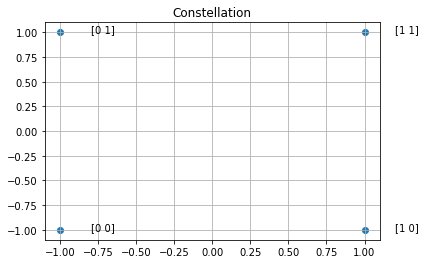

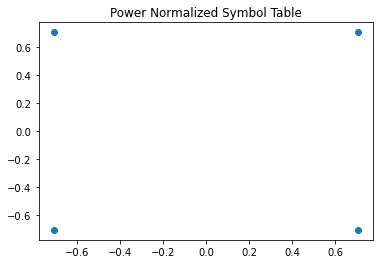

In [4]:





m = QAMModem(nsymbols)
con = m.constellation
con = con/np.max(np.abs(con))  # power normalizing


#
# There is non-unit amplitude in this constellation plot which can cause issues.
#
pyplot.close("all")
m.plot_constellation()
con
pyplot.close("all")
pyplot.scatter(np.real(con), np.imag(con))
pyplot.title("Power Normalized Symbol Table")
pyplot.show()

In [5]:
symbol_message = np.random.randint(0, nsymbols, message_len)
symbol_message[:10]
message_with_repeats = np.repeat(symbol_message, repeats_per_symbol)
message_with_repeats[:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [6]:
#
# An IQ encoding of a message is just a symbol lookup table
#

iq_encoded_message = con[message_with_repeats]
iq_encoded_message

#
#
#

array([ 0.70710678+0.70710678j,  0.70710678+0.70710678j,
        0.70710678+0.70710678j, ..., -0.70710678+0.70710678j,
       -0.70710678+0.70710678j, -0.70710678+0.70710678j])

In [7]:
channel_iq = iq_encoded_message + np.random.normal(0,noise_sd/np.sqrt(2),len(iq_encoded_message)) +  1.j*np.random.normal(0,noise_sd/np.sqrt(2), len(iq_encoded_message))
channel_iq[:10]

array([0.70016007+0.7125848j , 0.70967698+0.70499129j,
       0.70914049+0.72234043j, 0.70626142+0.70738207j,
       0.70705291+0.71234809j, 0.71686622+0.71106643j,
       0.70019399+0.71083104j, 0.69356566+0.72327177j,
       0.70444528+0.71467386j, 0.70326443+0.71298504j])

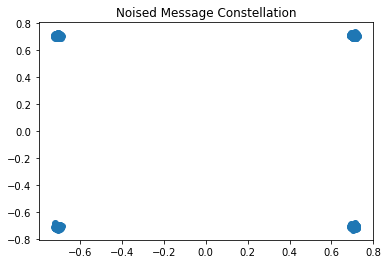

In [8]:
plt.close("all")
plt.scatter(np.real(channel_iq[:1000]), np.imag(channel_iq[:1000]))
plt.title("Noised Message Constellation")
plt.show()

In [9]:
modulated = channel_iq*baseband_signal

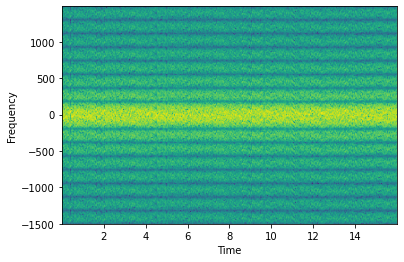

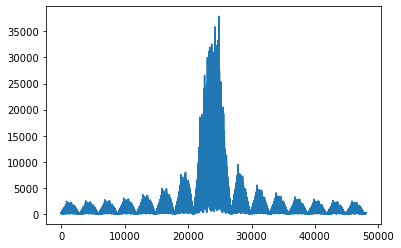

In [10]:
fftLen = len(modulated)  # perform 4-times zeropadding to get smoother spectrum
spectrum = lambda x: np.fft.fftshift(np.fft.fft(x, fftLen)) / baseband_carrier_freq * (len(modulated))
pyplot.close("all")
pyplot.specgram(modulated,Fs=baseband_carrier_freq)
pyplot.xlabel("Time")
pyplot.ylabel("Frequency")
pyplot.show()
#
# Pretty sure my units are screwed up here...
#
f = spectrum(modulated)
pyplot.close("all")
pyplot.plot(np.abs(f))
pyplot.show()

In [16]:
#
# better repeat scheme
#
symbol_message = np.random.randint(0, nsymbols, message_len)
symbol_message[:10]
pad_message = np.zeros(len(symbol_message)*repeats_per_symbol, dtype=complex)
indexes = np.arange(len(symbol_message))*repeats_per_symbol
pad_message[indexes] = con[symbol_message]
print(pad_message[:32])
hamming_filter = np.hamming(repeats_per_symbol)  # no idea if this is the right thing to convolve!
hamming_filter  = hamming_filter/np.sum(hamming_filter)
print(np.sum(hamming_filter))
#
# Note I didnt use the pad message here instead I convolved the iq_encoded message  I was curious what the difference in the spectrogram would be
#
smooth_iq_message= np.convolve(pad_message, hamming_filter, mode="same")
#smooth_iq_message =  np.convolve(iq_encoded_message,hamming_filter, mode="same")
print(smooth_iq_message[:32])

[-0.70710678+0.70710678j  0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.70710678-0.70710678j  0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j        ]
0.9999999999999999
[-0.08557443+0.08557443j -0.08557443+0.08557443j -0.07884913+0.07884913j
 -0.0665614 +0.0665614j  -0.05083589+0.05083589j -0.03439168+0.03439168j
 -0.02007214+0.02007214j -0.01035324+0.01035324j -0.00691547+0.00691547j
  0.00691547-0.00691547j  0.01035324-0.01035324j  0.02007214-0

In [17]:
smooth_channel_iq  = smooth_iq_message + np.random.normal(0,noise_sd/np.sqrt(2),len(iq_encoded_message)) +  1.j*np.random.normal(0,noise_sd/np.sqrt(2), len(iq_encoded_message))
smooth_channel_iq[:10]

array([-0.08536695+0.08520686j, -0.09315721+0.0819925j ,
       -0.08124484+0.08752457j, -0.07210175+0.06285898j,
       -0.05175707+0.04867498j, -0.02840531+0.02839492j,
       -0.0225265 +0.0197694j , -0.00709779+0.00524899j,
        0.00202344+0.00328134j, -0.01094174+0.00600002j])

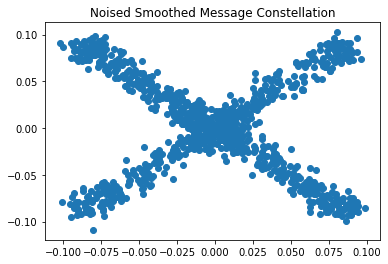

In [18]:
plt.close("all")
plt.scatter(np.real(smooth_channel_iq[:1000]), np.imag(smooth_channel_iq[:1000]))
plt.title("Noised Smoothed Message Constellation")
plt.show()

In [19]:
smooth_modulated = smooth_channel_iq*baseband_signal

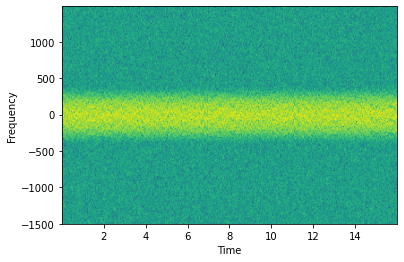

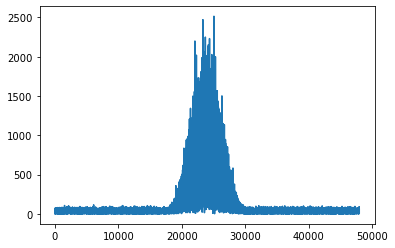

In [20]:
fftLen = len(modulated)  # perform 4-times zeropadding to get smoother spectrum
spectrum = lambda x: np.fft.fftshift(np.fft.fft(x, fftLen)) / baseband_carrier_freq * (len(modulated))
pyplot.close("all")
pyplot.specgram(smooth_modulated,Fs=baseband_carrier_freq)
pyplot.xlabel("Time")
pyplot.ylabel("Frequency")
pyplot.show()
#
# Pretty sure my units are screwed up here...
#
f = spectrum(smooth_modulated)
pyplot.close("all")
pyplot.plot(np.abs(f))
pyplot.show()

In [21]:
x = smooth_modulated



In [27]:
## Helper functions
def get_iq(df_s):
    """
    transform a df series of complex vals
    into the dataFrame of real and imaginary columns.
    Return: pandas.DataFrame
    """    
    dfc = {
        "i": (df_s.values).real,
        "q": (df_s.values).imag
    }
    
    return pd.DataFrame(dfc)

def detect_freq_range(f_caf, alpha=0.95):
    """
    View lagged correlation of signal to determine
    a frequency responce and filter out the decaying harmonics...
    Input: fft({lagged correlation function})
    
    """    
    #y = np.where(np.log(np.abs(f_caf)) > 0, np.log(np.abs(f_caf)), np.nan)
    y = np.log(np.abs(f_caf))
    peaks_caf =  find_peaks(y)[0]
    
    #create 95% confidence interval for population mean weight
    lb, ub = st.t.interval(alpha=alpha,
                  df=len(peaks_caf)-1,
                  loc=np.mean(peaks_caf),
                  scale=st.sem(peaks_caf)) 
    
    return lb, ub, peaks_caf, y

def pplot(df_s, df):
    """
    df_s is a dataframe series containing complex values for a scatter plot
    df is the full data frame so I can access the noise levels for coloring
    """
    df_iq = get_iq(df_s)
    color_ = 1 - np.abs(df["noise_vec"])/np.max(np.abs(df["noise_vec"]))
    df_iq["complement_noise_lvl"] = color_
    plt.close("all")
    df_iq.plot.scatter(x="i", y="q",c="complement_noise_lvl", colormap='viridis', alpha=color_ )
    plt.title(df_s.name)
    plt.show()

In [28]:
# Calculate the Asymetric CAF
# first calculate the asymetric Spectral Correlation Function,
# apply a shift to the Asym_SCF and inverse fft to get the Symmetric CAF value.

# print(x)

auto_cor = signal.correlate(x,
                       x,
                       mode="same")/len(x)

conj_auto_cor = signal.correlate(x,
                       np.conj(x),
                       mode="same")/len(x)

lags = signal.correlation_lags(x.size, x.size, mode="same")

a_cor = auto_cor[lags]
c_cor = conj_auto_cor[lags]


"""
view auto_correlation as an 
fft, and extrapulate the frequency range
with the highest periodic components.
"""

asym_scf = np.fft.fftshift(np.fft.fft(auto_cor))   
conj_asym_scf = np.fft.fftshift(np.fft.fft(conj_auto_cor))

# filter potential alpha values down to only those that describe
# the periodic components within the autocorrelate function.
lb, ub, peaks, y = detect_freq_range(asym_scf, alpha=0.99)
Taus = lags[int(lb):int(ub)]

ffreq =  np.fft.ifftshift(freqs)[Taus]
f_sort = np.argsort(ffreq)
ffreq = ffreq[f_sort]

# print(ffreq)

# print(Taus)


# Symmetric CAF around pre filtered alphas

alpha = Taus*dt
print(f"Is 0 in alpha {0 in alpha}")

s_scf = np.outer(np.exp(1j*np.pi*alpha), asym_scf[Taus]) # calculate the SCF for each alpha
ffreq = ffreq - alpha/2



print(s_scf.shape)

df_scf = pd.DataFrame(s_scf)
df_scf.index = [f"{np.round(f, 4)}Hz" for f in alpha]
df_scf.columns =  ffreq    
# [f"{np.round(f*dt, 4)}Hz" for f in freqs]
cols = df_scf.columns


NameError: name 'freqs' is not defined

In [29]:
import seaborn as sns

def psd(x):
    return 2*np.log10(np.abs(x))/len(x)


plt.close("all")
sns.heatmap(df_scf.transform(psd))
plt.show()

NameError: name 'df_scf' is not defined

In [ ]:
## I still believe I have too many frequencies and need to reduce my data set down
# Test 1. lets treat the freqs as features and the alphas as observations. 
#
# Sparse Principal Components Analysis (SparsePCA). [concept is to filter freqs as much as possible]

def psd(x):
    return 2*np.log10(np.abs(x))/len(x)

from sklearn.decomposition import PCA

X = np.transpose(df_scf.transform(psd)) # analysis on SCF... dimensionality reduction 

pca = PCA(n_components=10, random_state=0)
pca.fit(X)

X_pca = pca.transform(X)
print(X_pca.shape)



In [ ]:
import seaborn as sns
df_pca = pd.DataFrame(X_pca)
plt.close("all")
sns.heatmap(df_pca)
plt.show()